## Imports

In [1]:
# from class_source.idata_client import IData
from idmmonitor import IData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## API Code

In [2]:
# Variables to use
API_KEY = "58F2Z-RBUEV-6AJ4T-SL3IC"
print(API_KEY)

# initialise
idata = IData()
# echo request information on
#idata.set_verbose(True)

#Store the API Key in the package
idata.set_api_key(API_KEY)


result = idata.get_user_favorites()
if (result is None):
    print("Could not get the user datasources. Check terminal for errors.")
else:
    print(result)

print('')
print("End...")

58F2Z-RBUEV-6AJ4T-SL3IC

{'Metadata': {'Datasets': 22, 'Updated': '2021-12-30T15:46:48Z', 'TimeStamp': 2459579.1575, 'Page': 1, 'PageCount': 1, 'Rows': 22}, 'Datasets': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP', 'Name': 'ECB - Euro vs Pound Sterling', 'Description': 'European Central Bank exchange rate for Euro vs Pound Sterling (EUR/GBP)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'], 'BateIndex': [0], 'StartDate': '1999-01-04', 'EndDate': '2021-12-30', 'Values': 5941, 'Corrections': 0, 'Premium': False, 'Favorite': True, 'IsCategoryDS': False, 'Subscription': 'Active', 'Logo': 'http://adm-gui.intdatamedia.com/datasources/ECBLA.png', 'Status': 200, 'Details': 'OK'}, {'Datasource': 'ECBFX', 'Symbol': 'EURCNY', 'Name': 'ECB - Euro vs Chinese yuan Renminbi', 'Description': 'European Central Bank exchange rate for Euro vs Chinese yuan Renminbi (EUR/CNY)', 'Frequency': 'Day', 'Currency': None, 'Unit': None, 'Decimals': None, 'Bates': ['Close'],

## Get_User_Favorites()

In [3]:
result_1 = idata.get_dataset_values_rc([{"Datasource":"ECBFX","Symbol":"EURGBP"}, {"Datasource":"ECBFX","Symbol":"EURUSD"}])


-----------------------------------
POST
URL: 
https://api.idatamedia.org/
API: 
GetValuesRC
Payload: 
{'SessionToken': '1c9b356c54ce9d9ee0e22d5483b01a3b', 'Series': [{'Datasource': 'ECBFX', 'Symbol': 'EURGBP'}, {'Datasource': 'ECBFX', 'Symbol': 'EURUSD'}], 'StartDate': 'Earliest', 'EndDate': 'Latest', 'Periods': 0, 'CommonStart': 'false', 'CommonEnd': 'false', 'CommonUA': 'true', 'DateFormat': 'YYYY-MM-DD', 'DateOrder': 'asc', 'Prefill': 'false', 'Fill': 'false', 'Frequency': 'd', 'Postfill': 'false', 'Rounding': 'auto', 'ReturnMetadata': 'false', 'ReturnAccess': 'false', 'ReturnParameters': 'false'}



Functions that help ous access the data.

In [4]:
def get_daily_data(dictionary):

    columns = dictionary['Columns']
    rows = dictionary['Rows']
    corrections = dictionary['Corrections']
    df = pd.DataFrame(rows.values(), columns = [columns[0]['Name'], columns[1]['Name']], index = rows.keys())
    df = df.reset_index()
    df.rename(columns = {'index':'Date'}, inplace = True)
    df.dropna(axis = 0, inplace = True)
    df["Date"] = pd.to_datetime(df['Date'])
    df.insert(1, 'Year', df.Date.dt.year)
    df.insert(2, 'Month', df.Date.dt.month)

    return df

def get_averages(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    theList_upd = {i+1:word for i,word in enumerate(theList)}

    df = df.groupby(['Year', 'Month'], as_index= False).agg({"ECB - Euro vs Pound Sterling": np.mean, "ECB - Euro vs US Dollar":np.mean})
    df['Month'] = df['Month'].replace(theList_upd)
    df.rename(columns = {"ECB - Euro vs Pound Sterling": "ECB - Euro vs Pound Sterling Mean", "ECB - Euro vs US Dollar": "ECB - Euro vs US Dollar Mean"}, inplace = True)
    return df

def get_processed(df):
    theList = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    eurgbp = df.iloc[:, :-1]
    eurusd = df.drop(columns = ['ECB - Euro vs Pound Sterling Mean'], axis = 1)
    datas = [eurgbp, eurusd]
    for num, data in enumerate(datas):    
        temp = []
        for i in range(0, len(data), 12):
            lists = data.iloc[i:i+12, -1].values.tolist()
            temp.append(lists)
        datas[num] = pd.DataFrame(temp, columns = theList, index = data.Year.unique().tolist()).round(3)
    datas = tuple(datas)
    
    return datas

Retrieving the data.

In [5]:
dataframe = get_daily_data(result_1)
dataframe.head()

,Date,Year,Month,ECB - Euro vs Pound Sterling,ECB - Euro vs US Dollar
0,1999-01-04,1999,1,0.71110,1.1789
1,1999-01-05,1999,1,0.71220,1.1790
2,1999-01-06,1999,1,0.70760,1.1743
3,1999-01-07,1999,1,0.70585,1.1632
4,1999-01-08,1999,1,0.70940,1.1659


The methods we will use require our data to be a Time-Series. That means the index of our Data-Frame has to be of type datetime. Also our data is recorded on bussiness days only, so we set frequency to "b", which means bussiness days.

In [6]:
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)
dataframe = dataframe.asfreq('b')
dataframe = dataframe.fillna(method='ffill')

We will monthly averages this time.

In [7]:
dataframe = dataframe.loc[:,["ECB - Euro vs Pound Sterling", "ECB - Euro vs US Dollar"]].groupby(pd.Grouper(freq='M')).mean()

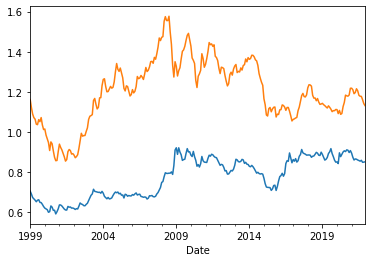

In [8]:
dataframe["ECB - Euro vs Pound Sterling"].plot()
dataframe["ECB - Euro vs US Dollar"].plot()

plt.show()

We run the PACF to estimate the optimal lag.

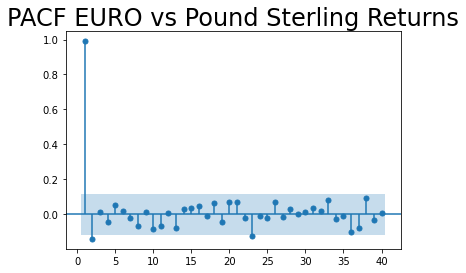

In [9]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_pacf(dataframe["ECB - Euro vs Pound Sterling"], lags = 40, zero = False, method = ('ols'))
plt.title("PACF EURO vs Pound Sterling Returns", size=24)
plt.show()

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.exceptions import ConvergenceWarning

model = ARIMA(dataframe["ECB - Euro vs Pound Sterling"], order=(23,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:     ECB - Euro vs Pound Sterling   No. Observations:                  276
Model:                          ARIMA(23, 1, 0)   Log Likelihood                 790.777
Date:                          Thu, 30 Dec 2021   AIC                          -1533.554
Time:                                  20:44:59   BIC                          -1446.752
Sample:                              01-31-1999   HQIC                         -1498.718
                                   - 12-31-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1367      0.052      2.640      0.008       0.035       0.238
ar.L2         -0.0286      0.055     -0.517      0.

Plot the residual.

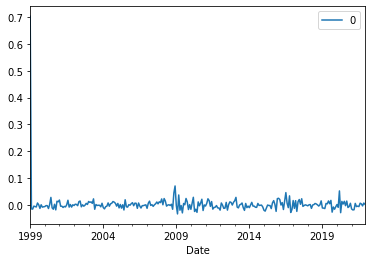

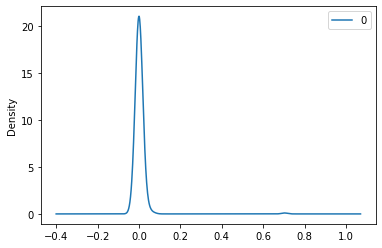

                0
count  276.000000
mean     0.003038
std      0.044422
min     -0.033164
25%     -0.007795
50%     -0.000133
75%      0.007021
max      0.702912


In [11]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

We will divide the set into test and train. We will re-train the model in each iteration of the test set and finally plot the predictions and actual values. We will also calculate the RMSE.

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = dataframe["ECB - Euro vs Pound Sterling"].values
train, test = X[0:-20], X[-20:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(23,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

Test RMSE: 0.011


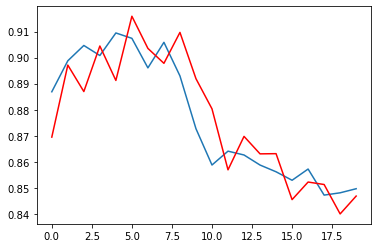

In [13]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()